In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630162 sha256=0c8f34f8b037b1758431a38b09b8eebde2b2d3998af65abb51ad580dac682801
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import Reader, Dataset, SVD
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates

In [ ]:
# Google Collab integration for files
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
credits = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/credits.csv')
keywords = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/keywords.csv')
links_small = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/links_small.csv')
md = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/movies_metadata.csv')
ratings = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/ratings_small.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [ ]:
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [ ]:
links_small.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
md.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
print('\n Columns of credits: ')
print(credits.columns)
print('\n Columns of keywords: ')
print(keywords.columns)
print('\n Columns of links_small: ')
print(links_small.columns)
print('\n Columns of movie meta data: ')
print(md.columns)
print('\n Columns of ratings: ')
print(ratings.columns)



 Columns of credits: 
Index(['cast', 'crew', 'id'], dtype='object')

 Columns of keywords: 
Index(['id', 'keywords'], dtype='object')

 Columns of links_small: 
Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

 Columns of movie meta data: 
Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

 Columns of ratings: 
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [ ]:
print('\n Shape of credits: ')
print(credits.shape)

print('\n Shape of keywords: ')
print(keywords.shape)

print('\n Shape of links_small: ')
print(links_small.shape)

print('\n Shape of meta data: ')
print(md.shape)

print('\n Shape of ratings: ')
print(ratings.shape)


 Shape of credits: 
(45476, 3)

 Shape of keywords: 
(46419, 2)

 Shape of links_small: 
(9125, 3)

 Shape of meta data: 
(45466, 24)

 Shape of ratings: 
(100004, 4)


In [ ]:
print('\nCredit dataframe information: \n')
print(credits.info())

print('\nkeywords dataframe information: \n')
print(keywords.info())

print('\nLinks dataframe information: \n')
print(links_small.info())

print('\nMovie meta data dataframe information: \n')
print(md.info())

print('\nRatings dataframe information: \n')
print(ratings.info())


Credit dataframe information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None

keywords dataframe information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB
None

Links dataframe information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 n

In [ ]:
print('\nCredit dataframe description: \n')
print(credits.describe())

print('\nkeywords dataframe description: \n')
print(keywords.describe())

print('\nLinks dataframe description: \n')
print(links_small.describe())

print('\nMovie meta data dataframe description: \n')
print(md.describe())

print('\nRatings dataframe description: \n')
print(ratings.describe())


Credit dataframe description: 

                  id
count   45476.000000
mean   108345.997537
std    112443.796536
min         2.000000
25%     26443.250000
50%     60002.500000
75%    157302.000000
max    469172.000000

keywords dataframe description: 

                  id
count   46419.000000
mean   109769.951873
std    113045.780256
min         2.000000
25%     26810.500000
50%     61198.000000
75%    159908.500000
max    469172.000000

Links dataframe description: 

             movieId        imdbId         tmdbId
count    9125.000000  9.125000e+03    9112.000000
mean    31123.291836  4.798244e+05   39104.545544
std     40782.633604  7.431774e+05   62814.519801
min         1.000000  4.170000e+02       2.000000
25%      2850.000000  8.884600e+04    9451.750000
50%      6290.000000  1.197780e+05   15852.000000
75%     56274.000000  4.284410e+05   39160.500000
max    164979.000000  5.794766e+06  416437.000000

Movie meta data dataframe description: 

            revenue       runt

In [ ]:
print('\nNull Values in Credits dataframe:\n'+str(credits.isnull().sum()))
print('\nNull Values in Keywords dataframe:\n'+str(keywords.isnull().sum()))
print('\nNull Values in Links dataframe:\n'+str(links_small.isnull().sum()))
print('\nNull Values in Movie metadata dataframe:\n'+str(md.isnull().sum()))
print('\nNull Values in Ratings dataframe:\n'+ str(ratings.isnull().sum()))


Null Values in Credits dataframe:
cast    0
crew    0
id      0
dtype: int64

Null Values in Keywords dataframe:
id          0
keywords    0
dtype: int64

Null Values in Links dataframe:
movieId     0
imdbId      0
tmdbId     13
dtype: int64

Null Values in Movie metadata dataframe:
adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vo

In [ ]:
md['timestamp'] = pd.to_datetime(ratings['timestamp'],unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
#md['timestamp'] = pd.to_datetime(md['timestamp']).dt.tz_localize('utc').dt.tz_convert('US/Eastern')

In [ ]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,timestamp
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,2009-12-13 21:52:24-05:00
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,2009-12-13 21:52:59-05:00
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,2009-12-13 21:53:02-05:00
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,2009-12-13 21:53:05-05:00
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,2009-12-13 21:53:25-05:00


In [ ]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else [])


 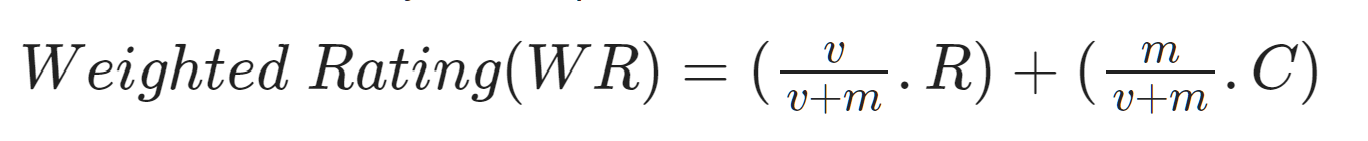
 
where,
    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole repor

In [ ]:
# this is V
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')

# this is R
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')

# this is C
C = vote_averages.mean()
C

5.244896612406511

The next step, we need to determine an appropriate value for m, the minimum votes required to be listed in the chart.

We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [ ]:
m = vote_counts.quantile(0.95)
m

434.0

In [ ]:
# Pre-processing step for getting year from date by splliting it using '-'

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
qualified = md[(md['vote_count'] >= m) & 
               (md['vote_count'].notnull()) & 
               (md['vote_average'].notnull())][['title', 
                                                'year', 
                                                'vote_count', 
                                                'vote_average', 
                                                'popularity', 
                                                'genres']]

qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Therefore, to qualify to be considered for the chart, a movie has to have at least 434 votes on TMDB.

We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10.

Here, only 2274 movies are qualify to be on our chart.




In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

Let us now construct our function that builds charts for particular genres.

In [ ]:
'''
>>> s
     a   b
one  1.  2.
two  3.  4.

>>> s.stack()
one a    1
    b    2
two a    3
    b    4
'''
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)
gen_md.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,timestamp,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,2009-12-13 21:52:24-05:00,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,2009-12-13 21:52:24-05:00,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,2009-12-13 21:52:24-05:00,1995,Family


In [ ]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: 
                        (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C),
                        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [ ]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


In [ ]:
def build_chart_year(year, percentile=0.85):
    df = gen_md[gen_md['year'] == year]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified_year = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & 
                   (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified_year['vote_count'] = qualified_year['vote_count'].astype('int')
    qualified_year['vote_average'] = qualified_year['vote_average'].astype('int')
    
    qualified_year['wr'] = qualified_year.apply(lambda x: 
                        (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C),
                        axis=1)
    year_qualified = qualified_year.sort_values('wr', ascending=False).head(250)
    
    return year_qualified

In [ ]:
build_chart_year('2005').head(15)

,title,year,vote_count,vote_average,popularity,wr
10122,Batman Begins,2005,7511,7,28.505341,6.951792
10122,Batman Begins,2005,7511,7,28.505341,6.951792
10122,Batman Begins,2005,7511,7,28.505341,6.951792
10554,Harry Potter and the Goblet of Fire,2005,5758,7,24.903058,6.937646
10554,Harry Potter and the Goblet of Fire,2005,5758,7,24.903058,6.937646
10554,Harry Potter and the Goblet of Fire,2005,5758,7,24.903058,6.937646
10069,Star Wars: Episode III - Revenge of the Sith,2005,4200,7,13.165421,6.915647
10069,Star Wars: Episode III - Revenge of the Sith,2005,4200,7,13.165421,6.915647
10069,Star Wars: Episode III - Revenge of the Sith,2005,4200,7,13.165421,6.915647
9888,Sin City,2005,2755,7,15.010525,6.874620


Content Based Recommendation

In [ ]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
## Pre-processing step

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
md['id'] = md['id'].apply(convert_int)
md[md['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,timestamp,year
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[Carousel Productions, Vision View Entertainme...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-02-03 16:35:15-05:00,NaT
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[Aniplex, GoHands, BROSTA TV, Mardock Scramble...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-07 11:21:37-04:00,NaT
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[Odyssey Media, Pulser Productions, Rogue Stat...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-03-14 16:31:10-04:00,NaT


In [ ]:
md = md.drop([19730, 29503, 35587])
md['id'] = md['id'].astype('int')
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 26)

*recommender* using movie descriptions and taglines.

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [ ]:
tfidf_matrix.shape

(9099, 268124)

Since TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score.

Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [ ]:
# http://scikit-learn.org/stable/modules/metrics.html#linear-kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
get_recommendations('The Godfather').head(10)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

Content based RS : Using movie description, taglines, keywords, cast, director and genres

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [ ]:
md.shape

(45463, 26)

In [ ]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [ ]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 29)

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: keyword, dtype: int64

In [ ]:
s = s[s > 1]

In [ ]:
# Stemmer Intialization
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
get_recommendations('The Dark Knight').head(10)

8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

##Collaborative Filtering

In [ ]:
# surprise reader API to read the dataset
reader = Reader()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

<generator object KFold.split at 0x7fb299ed5b50>

In [ ]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8942  0.8975  0.8938  0.9059  0.8961  0.8975  0.0044  
MAE (testset)     0.6901  0.6915  0.6897  0.6972  0.6888  0.6915  0.0030  
Fit time          4.87    5.00    7.86    11.88   4.92    6.91    2.73    
Test time         0.29    0.15    0.41    0.33    0.14    0.26    0.10    


{'fit_time': (4.868336200714111,
  5.003611326217651,
  7.858547925949097,
  11.880225419998169,
  4.922866344451904),
 'test_mae': array([0.69010095, 0.69152973, 0.68973688, 0.69722517, 0.68883095]),
 'test_rmse': array([0.89419877, 0.89748664, 0.89382809, 0.90589783, 0.89612107]),
 'test_time': (0.29313063621520996,
  0.14809203147888184,
  0.4123663902282715,
  0.3264505863189697,
  0.14424514770507812)}

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
svd.predict(1, 31)

Prediction(uid=1, iid=31, r_ui=None, est=2.5769205868175167, details={'was_impossible': False})

#Hybrid recommendation system

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')

In [ ]:
indices_map = id_map.set_index('id')

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Avatar')

,title,vote_count,vote_average,release_date,id,est
2014,Fantastic Planet,140.0,7.6,1973-05-01,16306,3.099541
8401,Star Trek Into Darkness,4479.0,7.4,2013-05-05,54138,3.074989
1621,Darby O'Gill and the Little People,35.0,6.7,1959-06-29,18887,2.991832
522,Terminator 2: Judgment Day,4274.0,7.7,1991-07-01,280,2.891887
1011,The Terminator,4208.0,7.4,1984-10-26,218,2.884848
8658,X-Men: Days of Future Past,6155.0,7.5,2014-05-15,127585,2.855931
344,True Lies,1138.0,6.8,1994-07-14,36955,2.850299
974,Aliens,3282.0,7.7,1986-07-18,679,2.832818
4966,Hercules in New York,63.0,3.7,1969-02-23,5227,2.769783
1668,Return from Witch Mountain,38.0,5.6,1978-03-10,14822,2.739697


In [ ]:
#NLP Questionarie

shut = False
found = 0 
print("Hello! you are now with moviebot \n")
while shut != True:
    print("Enter a movie name to recommend similar movies: \n")
    movie = input("Enter Movie \n")
    for i in range(len(md['original_title'])):
        if md['original_title'][i] == movie:
            found = 1        
    if found == 1:
        p = get_recommendations(movie)
        print("-------------Here are few similar movies-------------------")
        print(p)
        print('-------------------------------------------------------------')
    else:
        print("\n Sorry we cannot find the movie")
    print("\n Do you want to know more movies (Y/N):")
    t = input("")
    if t not in ['Y','N']:
        print("\n enter Valid input:")
    elif t == 'Y' or t == 'y':
        shut = False
    else:
        shut = True
        print("\n Have a Nice Day!")
        break
    found = 0   

Hello! you are now with moviebot 

Enter a movie name to recommend similar movies: 

Enter Movie 
ffdf

 Sorry we cannot find the movie

 Do you want to know more movies (Y/N):
N

 Have a Nice Day!


#Data Visualization

Checking the Null Values in datasets

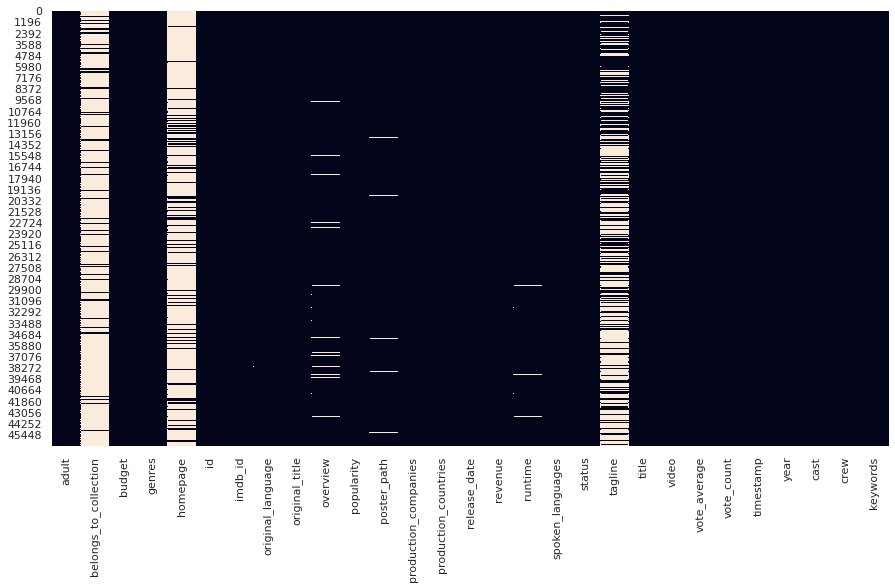

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(md.isnull(), cbar=False)

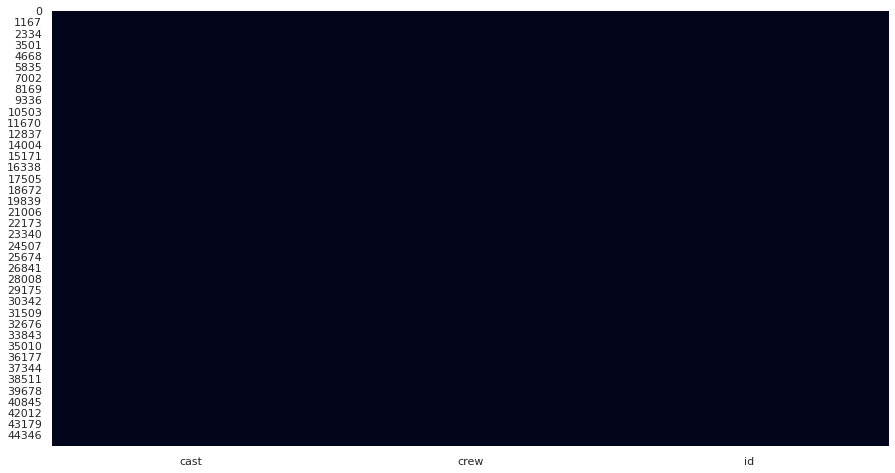

In [ ]:
sns.heatmap(credits.isnull(), cbar=False)

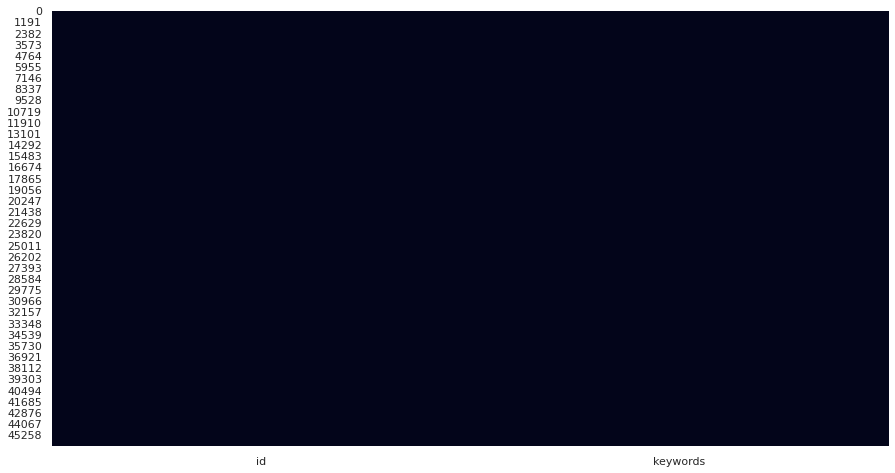

In [ ]:
sns.heatmap(keywords.isnull(), cbar=False)

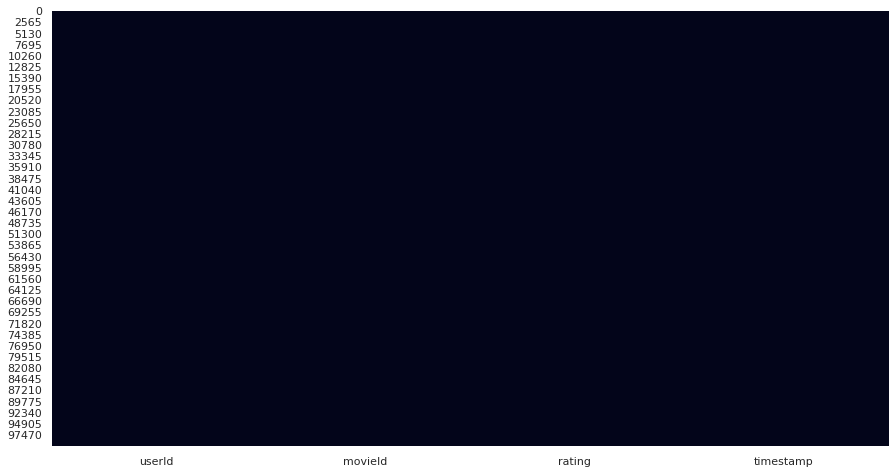

In [ ]:
sns.heatmap(ratings.isnull(), cbar=False)


                      id   revenue   runtime  vote_average  vote_count
id            1.000000 -0.070498 -0.118703     -0.163828   -0.064108
revenue      -0.070498  1.000000  0.102715      0.083340    0.812045
runtime      -0.118703  0.102715  1.000000      0.156864    0.112418
vote_average -0.163828  0.083340  0.156864      1.000000    0.122813
vote_count   -0.064108  0.812045  0.112418      0.122813    1.000000 
 


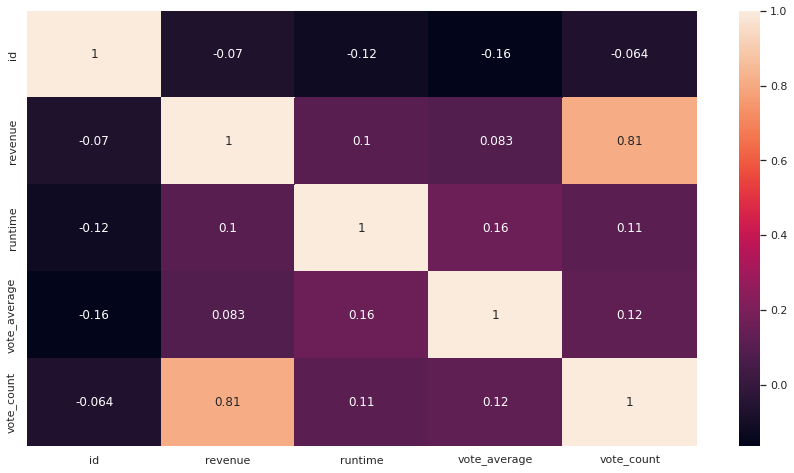

In [ ]:
correlation = md.corr()
sns.heatmap(correlation, annot=True)
print("\n ", correlation, "\n ")

1. Year vs number of movies

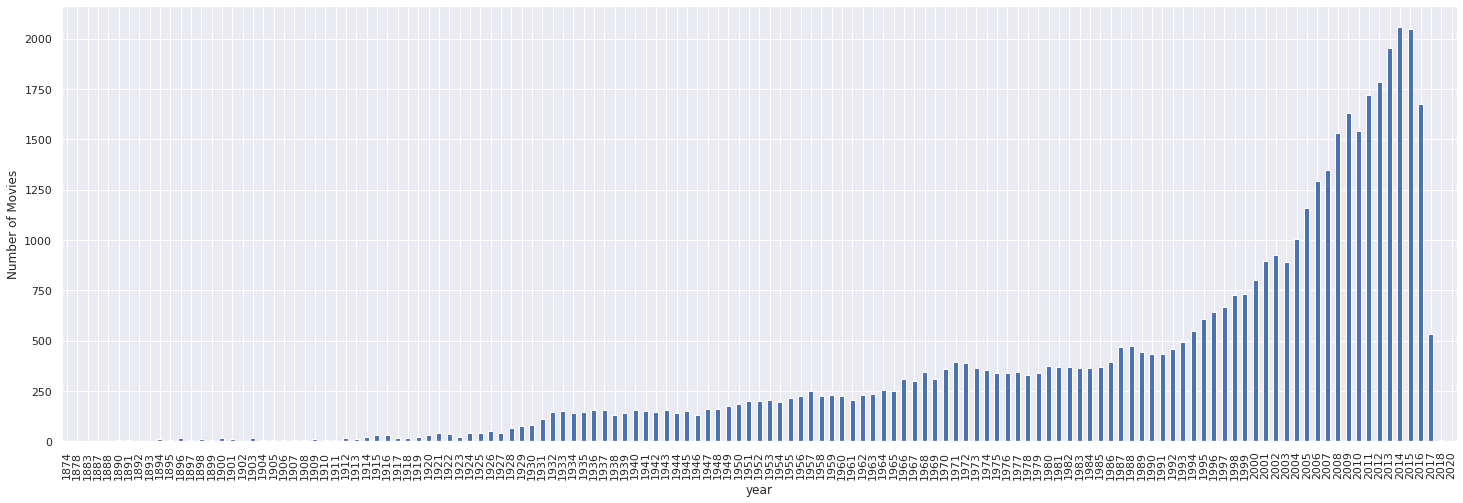

In [ ]:
filter = md['year'] != 'NaT'
md.loc[filter].groupby('year')['title'].count().plot(kind='bar', ylabel='Number of Movies',
                                         figsize = (25,8))
                                                      

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
import re
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
 

wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')
words = ''

for i in range(1000):
  edit_string = str(gen_md['overview'][i])
  edit_string = edit_string.lower()
  edit_string = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", edit_string)
  edit_string = " ".join([word for word in edit_string.split() if word not in (stop)])
  tokenization_words = nltk.word_tokenize(edit_string)
  for w in tokenization_words:
    w = wordnet_lemmatizer.lemmatize(w)
    if w not in words:
      words = words + ' ' + w



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


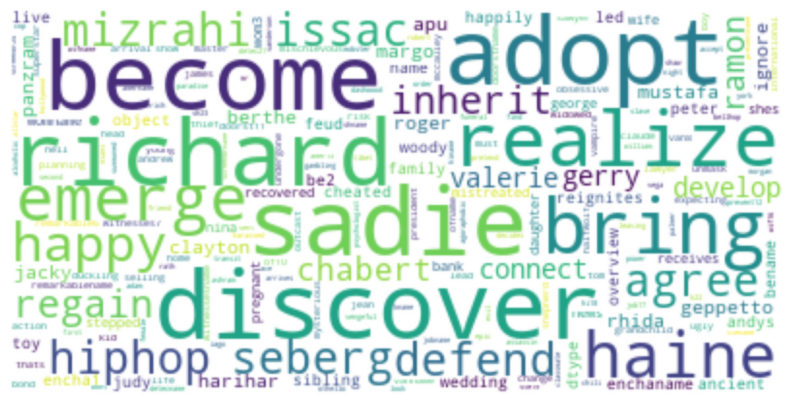

In [ ]:
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="white").generate(words)
plt.figure(figsize= (10,8), dpi=100)
plt.imshow(wordcloud, interpolation="gaussian")
plt.axis("off")
plt.show()

In [ ]:
coutry_movie = md[['production_countries','original_title']].loc[:15000]

In [ ]:
type(coutry_movie)

pandas.core.frame.DataFrame

In [ ]:
coutry_movie.shape

(15001, 2)

In [ ]:
coutry_movie.isnull().sum()

production_countries    0
original_title          0
dtype: int64

In [ ]:
coutry_movie = coutry_movie.dropna()

In [ ]:
coutry_movie.isnull().sum()

production_countries    0
original_title          0
dtype: int64

In [ ]:
coutry_movie['production_countries'] = coutry_movie['production_countries'].fillna('[United States of America]').apply(literal_eval).apply(lambda x: [i[
    'name'] for i in x] if isinstance(x, list) else 'United States of America')

In [ ]:
for i in range(len(coutry_movie)):
  j = coutry_movie['production_countries'][i]
  if len(j) >= 1:
    coutry_movie['production_countries'][i] = j[0]
  else:
    coutry_movie['production_countries'][i] = "United States of America"

In [ ]:
country = []
valuecount = []
count = 0

for i in range(len(coutry_movie)):
  if coutry_movie['production_countries'][i] not in country:
    country.append(coutry_movie['production_countries'][i])

for j in range(len(country)):
  for k in range(len(coutry_movie)):
    if country[j] == coutry_movie['production_countries'][k]:
      count += 1
  valuecount.append(count)
  count = 0

In [ ]:
len(valuecount)

98

In [ ]:
zipped = list(zip(country, valuecount))
df = pd.DataFrame(zipped, columns=['country', 'count'])
df

,country,count
0,United States of America,9043
1,Germany,552
2,United Kingdom,1238
3,France,923
4,Italy,321
...,...,...
93,United States Minor Outlying Islands,1
94,Latvia,1
95,Chad,1
96,Kazakhstan,1


In [ ]:
coutry_moviefig = px.scatter_geo(df,
                                            locations=df['country'],
                                            locationmode='country names', size=df['count'],
                                            projection ='orthographic',
                                            color=df['count'],
                                            hover_data = (['country', 'count']),
                                            labels={"country": "Country Name ", "count": "Movie count "}
                                            )

coutry_moviefig.update_layout(
    title_text='Country Vs Movie count',
    showlegend=False,
    geo=dict(
       showframe=True,
       showcoastlines=True,
       oceancolor='blue',
       projection_type='orthographic'
    ),

    font=dict(
       family='Arials',
       size=14, 
       color='black'
    )
)
coutry_moviefig.show()

In [ ]:
top_df = pd.read_csv(r'/content/gdrive/My Drive/Data690NLP/topmovies.csv')
top_df = top_df.head(5).sort_values(by='vote_average')

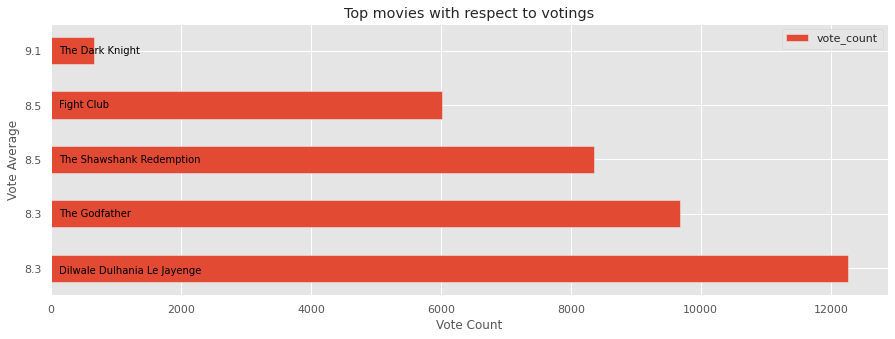

In [ ]:
plt.style.use('ggplot')
top_df.plot.barh(x='vote_average', y='vote_count', figsize=(15, 5))
plt.xlabel('Vote Count')
plt.ylabel('Vote Average')
position_list = [-0.1, 0.95, 1.95, 2.95, 3.95]
labels = top_df['title'].tolist()
for i in range(5):
  plt.text(125,position_list[4-i],labels[i], color='Black')
plt.title('Top movies with respect to votings')
plt.show()

In [ ]:
pip install IMDbPY

     |████████████████████████████████| 298 kB 5.2 MB/s 


In [ ]:
import imdb

In [ ]:
ia = imdb.IMDb()

In [ ]:
help(ia)

Help on IMDbHTTPAccessSystem in module imdb.parser.http object:

class IMDbHTTPAccessSystem(imdb.IMDbBase)
 |  IMDbHTTPAccessSystem(adultSearch=True, proxy=-1, cookie_id=-1, timeout=30, cookie_uu=None, *arguments, **keywords)
 |  
 |  The class used to access IMDb's data through the web.
 |  
 |  Method resolution order:
 |      IMDbHTTPAccessSystem
 |      imdb.IMDbBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, adultSearch=True, proxy=-1, cookie_id=-1, timeout=30, cookie_uu=None, *arguments, **keywords)
 |      Initialize the access system.
 |  
 |  del_cookies(self)
 |      Remove the used cookie.
 |  
 |  do_adult_search(self, doAdult, cookie_id=None, cookie_uu=None)
 |      If doAdult is true, 'adult' movies are included in the
 |      search results; cookie_id and cookie_uu are optional
 |      parameters to select a specific account (see your cookie
 |      or cookies.txt file.
 |  
 |  get_company_main(self, companyID)
 |  
 |  get_imdbCompan

In [ ]:
movies = ia.get_top250_movies()  
movie_list = []
year_list = []
for movie in movies:
     title = movie['title']
     movie_list.append(title)
     year = movie['year']
     year_list.append(year)

movie_df = pd.DataFrame()
movie_df['title'] = movie_list
movie_df['year'] = year_list
movie_df['rating'] = np.zeros(len(movie_df))
movie_df['rating']= [(np.random.uniform(8.5, 8.8)) for x in movie_df['rating']]
movie_df.head()   

,title,year,rating
0,The Shawshank Redemption,1994,8.760950
1,The Godfather,1972,8.562880
2,The Dark Knight,2008,8.636833
3,The Godfather: Part II,1974,8.644824
4,12 Angry Men,1957,8.553720


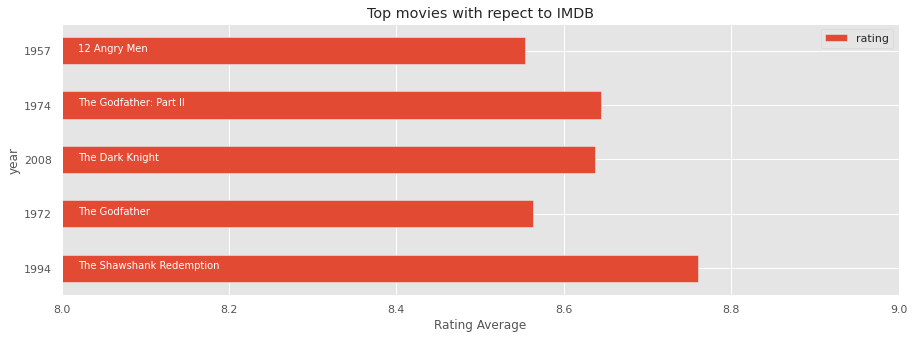

In [ ]:
movie_df.head().plot.barh(x='year', y='rating', figsize=(15, 5))
plt.xlabel('Rating Average')
plt.ylabel('year')
plt.xlim([8, 9])
position_list = [3.99, 2.99, 1.99, 0.99, 0]
labels = movie_df['title'].tolist()
for i in range(5):
  plt.text(8.02,position_list[4-i],labels[i], color='white')
plt.title('Top movies with repect to IMDB')

plt.show()

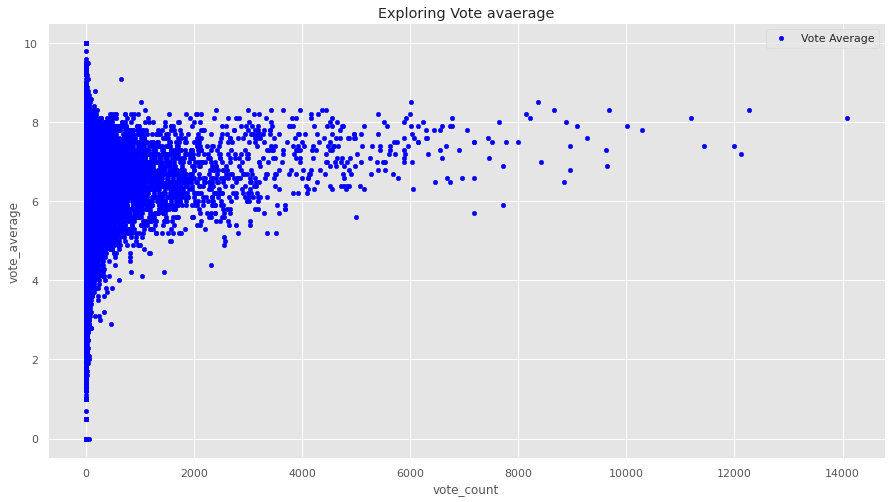

In [ ]:
md.plot(kind='scatter',
        x='vote_count',
        y='vote_average',
        title='Exploring Vote avaerage',
        label='Vote Average',
        c = 'blue')

In [ ]:
ppd = smd[['revenue','year']]

In [ ]:
revenue_mean = ppd['revenue'].mean()
for i in ppd:
  if i[0] == 0:
    i[0] = revenue_mean

In [ ]:
ppd.isnull().sum()

revenue    0
year       0
dtype: int64

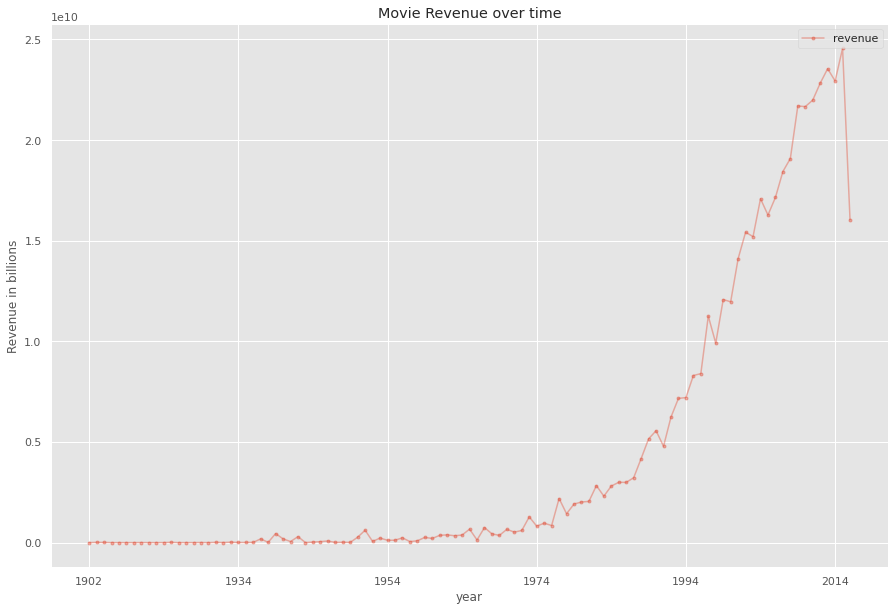

In [ ]:
ppd.groupby('year').agg({'revenue':'sum'}).plot(rot=0,
                                                figsize=(15,10),
                                                marker='.',
                                                alpha=0.4,
                                                ylabel = 'Revenue in billions',
                                                title = "Movie Revenue over time")